<a href="https://colab.research.google.com/github/AkankshaK-AI/S6-Assignment/blob/main/EVA7S6_GN_StepLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Performing image augmentation

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

Adding image augmentation

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics



In [6]:
# We'd need to convert it into Numpy! Above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [7]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Getting mean and std values for the transforms



In [8]:

# simple_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                       #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])
# exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
# exp_data = exp.train_data
# exp_data = exp.transform(exp_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', exp.train_data.size())
# print(' - min:', torch.min(exp_data))
# print(' - max:', torch.max(exp_data))
# print(' - mean:', torch.mean(exp_data))
# print(' - std:', torch.std(exp_data))
# print(' - var:', torch.var(exp_data))

# The model


In [9]:
# dropout_value=0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(5,10),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=28*28,output_size =26*26, RF=3*3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(10,20),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=26*26,output_size =24*24, RF=5*5

        # Transition block 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=24*24,output_size =24*24, RF=5*5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12*12, RF=6*6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(8,16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=12*12, output_size = 10*10, RF=10*10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(8,16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=10*10, output_size = 8*8, RF=14*14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(8,16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=8*8, output_size = 6*6, RF=18*18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(8,16),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # input_size=6*6, output_size = 6*6, RF=22*22

        # OUTPUT BLOCK  
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1*1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
        ) # adding parameters after GAP layer



        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
         GroupNorm-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 20, 24, 24]           1,800
         GroupNorm-5           [-1, 20, 24, 24]              40
              ReLU-6           [-1, 20, 24, 24]               0
            Conv2d-7           [-1, 10, 24, 24]             200
         MaxPool2d-8           [-1, 10, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,440
        GroupNorm-10           [-1, 16, 10, 10]              32
             ReLU-11           [-1, 16, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           2,304
        GroupNorm-13             [-1, 16, 8, 8]              32
             ReLU-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing



Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = [] # train accuracy
test_acc = [] #test accuracy
misclassified = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

# Let's Train and test our model

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.18408821523189545 Batch_id=468 Accuracy=71.95: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]



Test set: Average loss: 0.2207, Accuracy: 9464/10000 (94.64%)

EPOCH: 1


Loss=0.07552390545606613 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]



Test set: Average loss: 0.0672, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.04018791392445564 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]



Test set: Average loss: 0.0556, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.08726972341537476 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]



Test set: Average loss: 0.0527, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.0405396930873394 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]



Test set: Average loss: 0.0360, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.030168406665325165 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]



Test set: Average loss: 0.0326, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.035919707268476486 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0310, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.049619436264038086 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0296, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.018385088071227074 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]



Test set: Average loss: 0.0337, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


Loss=0.010812097229063511 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]



Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.011532044969499111 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]



Test set: Average loss: 0.0327, Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Loss=0.004239776637405157 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]



Test set: Average loss: 0.0304, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.020704330876469612 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.01971861720085144 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]



Test set: Average loss: 0.0297, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.022084785625338554 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.0008415639749728143 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0293, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.058295950293540955 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]



Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.060568779706954956 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.01891982927918434 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]



Test set: Average loss: 0.0226, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.007890702225267887 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]



Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)



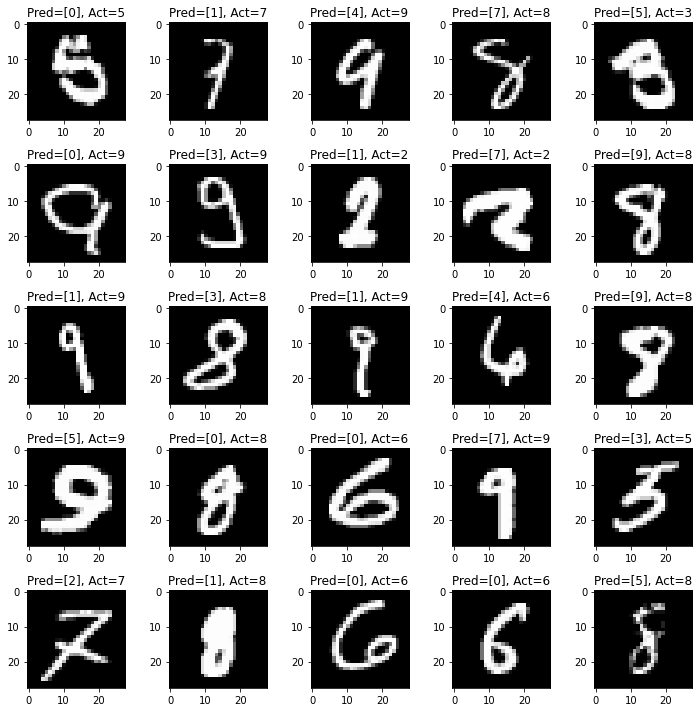

In [16]:
from torch.optim.lr_scheduler import StepLR  # We have added Step LR here. We will be dropping the LR after every 6 epochs

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #We will be dropping the LR by 0.1 after every 6 epochs

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, misclassified)


plot_misclassified(misclassified)

Text(0.5, 1.0, 'Test Accuracy')

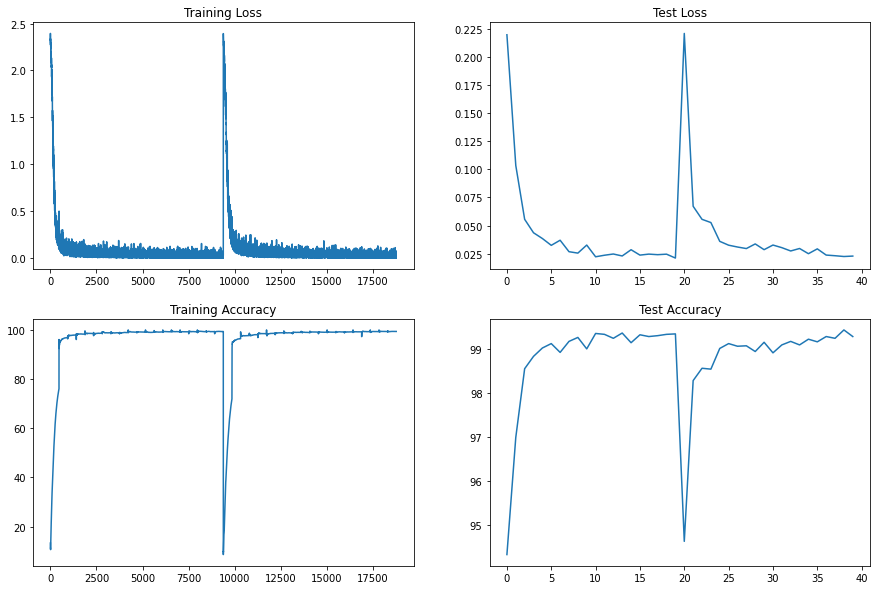

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")